# Problema 47
## 47)
Integremos el movimiento de 3 cuerpos en configuración pitagórica (2-D). Esto es <br>
### <center> $\vec r_1 = (0,0)$ ; $\vec r_2 = (4,0)$ ; $\vec r_3 = (4,3)$ </center>
### <center> $m_1 = 5$ ; $m_2 = 4$ ; $m_3 = 3$ </center>
Grafiquemos la distribución inicial, e integremos durante $t = 100$, con un step de $h = 0.001$, suponiendo $G = 1$ y utilizando el método de integración **LF-KDK**.

In [8]:
#No sé por qué el otro no me da bola, copiemos y peguemos el N-Body de Julia, pero con los 3 posc inic definidas a mano

using Plots
using Random
using LinearAlgebra
using Statistics

function distrib(n=3) #n = cant de partículas
                               #L = size del box 2D
                               #s = seed a elegir (para cambiar if I wanna)
    
    #Random.seed!(s) #pickeo seed
    
    #pos = rand(n,3).*L #randoms uniformes entre 0 y L. No separo en "(x,y)" porque si dejo 1 seed se repiten
    
    x = [1.,5.,5.]
    y = [1.,1.,4.]
    
    m = [5.,4.,3.] #masas
    
    plt = scatter(x,y, xlabel="x", ylabel="y", title = "Distribución inicial",
        ms=m.*2,color=["yellow","blue","red"], grid = true,size=(700,700)) #ploteo
    
    x_cm = sum(m .* x)/sum(m)
    y_cm = sum(m .* y)/sum(m)
    
    plt = scatter!([x_cm],[y_cm],color="black",seriestype = :scatter,label="CM", legend=:topleft,  ms=5, shape=:cross)
    
    display(plt)
    
    #Energía:
    
    E = 0.
    
    for i in 1:3
        for j in 1:3
            if i == j
                continue
            else
                d = norm((x[i]-x[j],y[i]-y[j]))
                E += -m[j]/d
            end        
        end
        
    end
    
    return x,y,m,E
end

distrib (generic function with 2 methods)

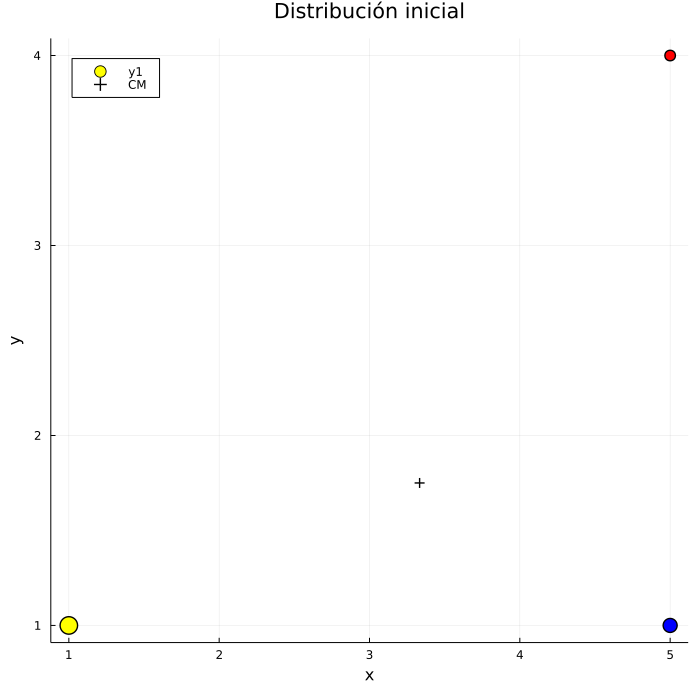

([1.0, 5.0, 5.0], [1.0, 1.0, 4.0], [5.0, 4.0, 3.0], -6.183333333333333)

In [9]:
x,y,m,E0 = distrib(3)

In [10]:
#Aceleración:

function a(x=x,y=y,e=0.1,n=size(x)[1],m=m)  #aceleración de cada partícula debido al resto (sup G = 1)
                                #e = softening; n = cant de part, debe ser = al n de distrib
        
    ax = zeros(n)
    ay = zeros(n)
    
    for i in 1:n
        
        Sx = 0 #Var para sum. Para c/ part debo ver cómo le afectan las demás
        Sy = 0 #Direcc ortog => lo puedo cal por separado
        
        for j in 1:n
            if i == j
                continue
            else
                r = norm((x[i]-x[j],y[i]-y[j])) #módulo del vector dif entre particulas i y j
                Sx += (r^2 + e^2)^-1.5 * (x[i]-x[j]) * m[j]
                Sy += (r^2 + e^2)^-1.5 * (y[i]-y[j]) * m[j]   
            end
    
        ax[i] = -Sx/m[i]
        ay[i] = -Sy/m[i] #numpy no me deja hacer arrays de arrays, así que div ax de ay
                
        end 
                
    end
        
    return ax,ay #a = un array de n listas (= cant de aprticulas), con las aceleraciones en x y en y de cada espacio
                
end

a (generic function with 6 methods)

In [11]:
function LF(a=a,x=x,y=y,n=10_000,t=100,N=size(x)[1],m=m)
            #(x,y) listas vacías excepto por las pos inic, (vx,vy) variables, pero comenzamos con las v inic.
            # a = (ax,ay) func para obtener la aceleración; n = cant de pasos; t = tiempo de integ
            # N = cant de part = n anteriores    
    kx = zeros(N)
    ky = zeros(N)
    vx = zeros(N)
    vy = zeros(N) #v inic = 0, estos se van a ir sobreescribiendo
    
    dE = zeros(n) #Delta E para c/ step
    
    h = t/n
    
    for l in 1:n #pasos a realizar
        
        E = 0.
        
        for i in 1:N #cant de partículas
        
            kx[i] = vx[i] + a(x,y)[1][i]*h/2 #la func a se come las posiciones de todas las partículas, pero
                                             #siempre estoy viendo la particula i, y actualizo las pos y vel de cada part a la vez
                                             #antes de saltar al prox step m
            
            ky[i] = vy[i] + a(x,y)[2][i]*h/2
            
        end
            
        for i in 1:N #Debo ir actualizando k, x y v de todas las part antes de pasar al prox parám (k -> x -> v) 

            x[i] = x[i] + kx[i]*h
            y[i] = y[i] + ky[i]*h
            
            #println(x[1])
            
        end
            
        for i in 1:N

            vx[i] = kx[i] + a(x,y)[1][i]*h/2 #Esta a es con las pos de TODAS las part actualizadas (no sólo de 1, que es lo que
                                             # pasaría si estuvieran k, x y v en el mismo loop)
            vy[i] = ky[i] + a(x,y)[2][i]*h/2
            
        end
        
        for i in 1:N
            for j in 1:N
                if i == j
                    continue
                else
                    d = norm((x[i]-x[j],y[i]-y[j]))
                    E += -m[j]/d
                end        
            end

            E += 0.5*m[i]*(norm(vx[i],vy[i]))^2
            
        end
        
        dE[l] = (E-E0)/E0
        
        #Y ahora si podemos pasar al prox step, guardando imags para la prox anim
        
        if mod(l,50) == 0

            plt = scatter(x,y, xlabel="x", ylabel="y", title = "N-body",
                       color=["yellow","blue","red"],seriestype = :scatter, legend=false, ms=m, grid = true,
                       xlim = (-2,10), ylim = (-2,10),size=(1000,1000)) #ploteo

            x_cm = sum(m .* x)/sum(m)
            y_cm = sum(m .* y)/sum(m)

            plt = scatter!([x_cm],[y_cm],color="black",seriestype = :scatter,label="CM", legend=true,  ms=5, shape=:cross)

            #display(plt)
            savefig(plt,"N100_$l.png")
            
        end
     
    end
                        
    return x,y,dE#Para seguirlo si quiero desde donde lo dejó. Funcó

end

LF (generic function with 8 methods)

No vamos a correr el integrador ahora, pero dejamos la animación que resulta a continuación:

https://drive.google.com/file/d/1ppIW4_lN5apmm4_uABzzz0RqVVmCu44g/view?usp=sharing

In [12]:
#x,y,dE = LF()

([4.11551558105072, 1.8512678572518027, 1.9435360841885887], [0.21372856626970785, 3.2282880115541674, 2.222686406487098], [2.48262564173994e-6, 9.930645899852484e-6, 2.2344490796141963e-5, 3.972487711443743e-5, 6.207280852211272e-5, 8.938957573929518e-5, 0.0001216767567567687, 0.00015893621710486906, 0.00020117011016618976, 0.00024838087754272775  …  0.5547527860738838, 0.564131552909402, 0.5737596459174574, 0.5836453495054821, 0.5937972688145514, 0.6042243409870498, 0.6149358464413873, 0.6259414200720645, 0.6372510622771285, 0.6488751496961445])

Y veamos la variación de energía del sistema:

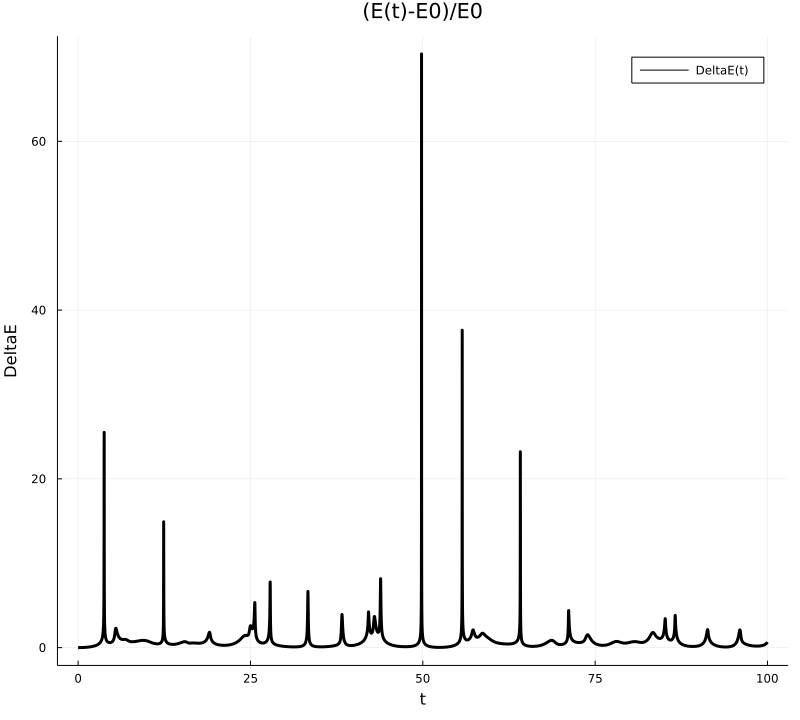

In [13]:
t = LinRange(0,100,10_000)
p = plot(t,dE,title="(E(t)-E0)/E0",lw=3,color="black",label="DeltaE(t)",xlabel="t",ylabel="DeltaE",size=(800,720))
display(p)
#savefig(p,"DeltaE_t.png")